In [7]:
import os
from pydub import AudioSegment

# Define the input directory containing audio files and output directory
input_directory = 'data'  # Change this to your input directory
output_directory = 'wav_files'

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Convert all audio files in the input directory to WAV format
for filename in os.listdir(input_directory):
    if filename.endswith(('.mp4', '.mp3', '.ogg', '.flac', '.m4a', '.wma', '.mkv')):  # Add other formats as needed
        file_path = os.path.join(input_directory, filename)
        try:
            # Load the audio file
            audio = AudioSegment.from_file(file_path)
            # Define output file path
            output_file_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}.wav")
            # Export as WAV
            audio.export(output_file_path, format='wav')
            print(f"Converted {filename} to {output_file_path}")
        except Exception as e:
            print(f"Failed to convert {filename}: {e}")

Converted Voice 002 (2).m4a to wav_files/Voice 002 (2).wav
Converted English 1st conversation.m4a to wav_files/English 1st conversation.wav
Converted progga.m4a to wav_files/progga.wav
Converted keralas calture.mp3 to wav_files/keralas calture.wav
Converted SS practice.mp3 to wav_files/SS practice.wav
Converted R10.m4a to wav_files/R10.wav
Converted Oct hhjh.mp3 to wav_files/Oct hhjh.wav
Converted Voice 001_sd.m4a to wav_files/Voice 001_sd.wav
Converted 2024-02-27 21-05-26.mkv to wav_files/2024-02-27 21-05-26.wav
Converted cricket toppic.m4a to wav_files/cricket toppic.wav
Converted Voice 002.m4a to wav_files/Voice 002.wav
Converted sanjid meyad.mp3 to wav_files/sanjid meyad.wav
Converted R7.m4a to wav_files/R7.wav
Converted Voice 003.m4a to wav_files/Voice 003.wav
Converted tamanna.m4a to wav_files/tamanna.wav
Converted Voice 001 (2).m4a to wav_files/Voice 001 (2).wav
Converted Voice 001.m4a to wav_files/Voice 001.wav
Converted Oct 7, 9.34 AM.mp3 to wav_files/Oct 7, 9.34 AM.wav
Conver

In [1]:
import os
import json
import librosa
import numpy as np
import pandas as pd

# Paths to JSON and audio files
json_folder = 'JSON'
audio_folder = 'wav_files'

# Match audio and JSON files
json_files = {os.path.splitext(f)[0]: os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')}
audio_files = {os.path.splitext(f)[0]: os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(('.wav', '.m4a', '.mp3'))}

matched_files = {name: (json_files[name], audio_files[name]) for name in json_files if name in audio_files}

print(matched_files)

{'cricket toppic': ('JSON/cricket toppic.json', 'wav_files/cricket toppic.wav'), 'R1': ('JSON/R1.json', 'wav_files/R1.wav'), 'New Recording 6': ('JSON/New Recording 6.json', 'wav_files/New Recording 6.wav'), 'Mirpur Road': ('JSON/Mirpur Road.json', 'wav_files/Mirpur Road.wav'), 'Recording_1': ('JSON/Recording_1.json', 'wav_files/Recording_1.wav'), 'Oct 7, 9.34 AM': ('JSON/Oct 7, 9.34 AM.json', 'wav_files/Oct 7, 9.34 AM.wav'), 'keralas calture': ('JSON/keralas calture.json', 'wav_files/keralas calture.wav'), 'the scientist': ('JSON/the scientist.json', 'wav_files/the scientist.wav'), 'Recording_2': ('JSON/Recording_2.json', 'wav_files/Recording_2.wav'), 'R5': ('JSON/R5.json', 'wav_files/R5.wav'), 'Sep 23, 9.24 AM': ('JSON/Sep 23, 9.24 AM.json', 'wav_files/Sep 23, 9.24 AM.wav'), 'English 1st conversation': ('JSON/English 1st conversation.json', 'wav_files/English 1st conversation.wav'), 'SS practice': ('JSON/SS practice.json', 'wav_files/SS practice.wav'), 'sanjid meyad': ('JSON/sanjid m

In [2]:
print(len(matched_files))

18


In [3]:
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = []
    for item in data[0]['annotations'][0]['result']:
        if item['type'] == 'labels':
            start = item['value']['start']
            end = item['value']['end']
            label = item['value']['labels'][0]
            annotations.append((start, end, label))
    return annotations

def extract_audio_segments(audio_file, annotations, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    segments = []
    for start, end, label in annotations:
        segment = y[int(start * sr):int(end * sr)]
        segments.append((segment, label))
    return segments

dataset = []
files_loaded = []

for name, (json_path, audio_path) in matched_files.items():
    if len(load_annotations(json_path)) != 0:
        files_loaded.append(json_path)
        annotations = load_annotations(json_path)
        audio_segments = extract_audio_segments(audio_path, annotations)
        dataset.extend(audio_segments)

In [4]:
print(files_loaded)

['JSON/cricket toppic.json', 'JSON/R1.json', 'JSON/New Recording 6.json', 'JSON/Mirpur Road.json', 'JSON/Recording_1.json', 'JSON/Oct 7, 9.34 AM.json', 'JSON/keralas calture.json', 'JSON/the scientist.json', 'JSON/Recording_2.json', 'JSON/R5.json', 'JSON/Sep 23, 9.24 AM.json', 'JSON/English 1st conversation.json', 'JSON/SS practice.json', 'JSON/sanjid meyad.json', 'JSON/Sep 25, 1.56 sa.json', 'JSON/Oct 20, 12.28 PM.json', 'JSON/Oct 6, 9.10 AM.json', 'JSON/R2.json']


In [5]:
def extract_features(segments, n_mfcc=40, max_length=300):
    features, labels = [], []
    for i, (segment, label) in enumerate(segments):
        try:
            # Dynamically adjust n_fft based on signal length
            n_fft = min(2048, len(segment))  # Use the smaller of 2048 or segment length

            # Extract MFCC features with adjusted n_fft
            mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=n_mfcc, n_fft=n_fft)

            # Handle variable lengths (pad if short, truncate if long)
            if mfcc.shape[1] < max_length:
                padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
            else:
                padded_mfcc = mfcc[:, :max_length]

            # Append features and labels
            features.append(padded_mfcc.T)
            labels.append(0 if label == 'Field pause' else 1)

        except Exception as e:
            print(f"Error processing segment {i}: {e}")

    return np.array(features), np.array(labels)

X, y = extract_features(dataset)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(x, x)
    x = Dropout(dropout_rate)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1]),
    ])(x)
    return x + res


def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = build_transformer_model(input_shape=(300, 40), num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 300, 40)   │         80 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 300, 40)   │     41,768 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300, 40)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 300, 40)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 300, 40)   │         80 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 300, 40)   │     10,408 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 300, 40)   │          0 │ sequential[0][0], │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 40)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         82 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,418 (204.76 KB)

 Trainable params: 52,418 (204.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5662 - loss: 6.3593 - val_accuracy: 0.9860 - val_loss: 0.2257
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.9570 - loss: 0.7558 - val_accuracy: 0.9895 - val_loss: 0.1298
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step - accuracy: 0.9741 - loss: 0.4910 - val_accuracy: 0.9895 - val_loss: 0.0986
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9645 - loss: 0.4075 - val_accuracy: 0.9895 - val_loss: 0.0768
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9768 - loss: 0.1716 - val_accuracy: 0.9895 - val_loss: 0.0614
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9764 - loss: 0.1952 - val_accuracy: 0.9895 - val_loss: 0.0684
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9726 - loss: 0.2538 - val_accuracy: 0.9895 - val_loss: 0.0460
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.9753 - loss: 0.2475 - val_accur

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=17)

Epoch 1/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.9780 - loss: 0.1399 - val_accuracy: 0.9930 - val_loss: 0.0261
Epoch 2/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9871 - loss: 0.0736 - val_accuracy: 0.9860 - val_loss: 0.0342
Epoch 3/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.9854 - loss: 0.0707 - val_accuracy: 0.9895 - val_loss: 0.0364
Epoch 4/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.9873 - loss: 0.0606 - val_accuracy: 0.9860 - val_loss: 0.0373
Epoch 5/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9881 - loss: 0.0532 - val_accuracy: 0.9895 - val_loss: 0.0262
Epoch 6/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.9846 - loss: 0.0891 - val_accuracy: 0.9860 - val_loss: 0.0366
Epoch 7/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.9894 - loss: 0.0755 - val_accuracy: 0.9895 - val_loss: 0.0352
Epoch 8/17
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.9951 - loss: 0.0178 - val_accu

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

In [12]:
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (996, 300, 40), (996,)
Validation set: (213, 300, 40), (213,)
Test set: (214, 300, 40), (214,)


In [15]:
import random
from sklearn.model_selection import train_test_split

# Define hyperparameter ranges
param_grid = {
    'batch_size': [10, 17, 20, 25, 32, 64],                    # Batch sizes
    'epochs': [10, 20, 30, 40, 50],                           # Epoch counts
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],                # Learning rates
    'dropout_rate': [0.01, 0.1, 0.3, 0.5],                    # Dropout rates
    'head_size': [32, 64, 128],                               # Transformer head sizes
    'num_heads': [2, 4, 8],                                   # Number of attention heads
    'ff_dim': [64, 128, 256],                                 # Feed-forward dimensions
    'loss_function': ['binary_crossentropy', 'hinge'],        # Loss functions
    'activation_function': ['sigmoid', 'softmax']             # Output layer activation functions
}

# Randomly sample combinations
n_trials = 50  # Number of random combinations to test
random_combinations = [
    {key: random.choice(values) for key, values in param_grid.items()}
    for _ in range(n_trials)
]
print(f"Random combinations to test: {len(random_combinations)}")

best_accuracy = 0
best_params = {}

# Perform RandomCV
for trial, params in enumerate(random_combinations):
    print(f"Trial {trial + 1}/{len(random_combinations)}: Testing parameters: {params}")
    
    # Build model with current hyperparameters
    def build_model(input_shape, num_classes, head_size, num_heads, ff_dim, dropout_rate, activation_function):
        inputs = Input(shape=input_shape)
        x = transformer_block(inputs, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(dropout_rate)(x)
        outputs = Dense(num_classes, activation=activation_function)(x)  # Dynamic activation
        return tf.keras.Model(inputs, outputs)

    # Compile model
    model = build_model(
        input_shape=(300, 40),
        num_classes=1,  # Binary classification requires 1 output node
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout_rate=params['dropout_rate'],
        activation_function=params['activation_function']
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss=params['loss_function'],  # Dynamic loss function
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Track the best parameters
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

# Output the best hyperparameters
print("Best hyperparameters:", best_params)
print("Best validation accuracy:", best_accuracy)

Random combinations to test: 50
Trial 1/50: Testing parameters: {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.0001, 'dropout_rate': 0.1, 'head_size': 64, 'num_heads': 8, 'ff_dim': 128, 'loss_function': 'binary_crossentropy', 'activation_function': 'softmax'}


/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy: 0.9859
Trial 2/50: Testing parameters: {'batch_size': 25, 'epochs': 20, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'head_size': 32, 'num_heads': 2, 'ff_dim': 256, 'loss_function': 'binary_crossentropy', 'activation_function': 'sigmoid'}
Validation Accuracy: 0.9859
Trial 3/50: Testing parameters: {'batch_size': 32, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'head_size': 64, 'num_heads': 8, 'ff_dim': 128, 'loss_function': 'binary_crossentropy', 'activation_function': 'softmax'}
Validation Accuracy: 0.9859
Trial 4/50: Testing parameters: {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'head_size': 128, 'num_heads': 2, 'ff_dim': 64, 'loss_function': 'binary_crossentropy', 'activation_function': 'softmax'}
Validation Accuracy: 0.9859
Trial 5/50: Testing parameters: {'batch_size': 17, 'epochs': 30, 'learning_rate': 0.1, 'dropout_rate': 0.01, 'head_size': 64, 'num_heads': 4, 'ff_dim': 128, 'loss_function': 'binary_crossentr

In [16]:
# Retrieve best hyperparameters
batch_size = best_params['batch_size']
epochs = best_params['epochs']
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']

# Build the final model
final_model = build_transformer_model(input_shape=(300, 40), num_classes=2)
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train the final model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.1790 - loss: 11.9956 - val_accuracy: 0.4038 - val_loss: 9.1917
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.5003 - loss: 7.2457 - val_accuracy: 0.5352 - val_loss: 5.4666
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6323 - loss: 4.4953 - val_accuracy: 0.7183 - val_loss: 2.6396
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.7852 - loss: 2.3519 - val_accuracy: 0.8779 - val_loss: 1.1509
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8915 - loss: 0.9979 - val_accuracy: 0.9155 - val_loss: 0.5729
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9219 - loss: 0.5200 - val_accuracy: 0.9390 - val_loss: 0.2952
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.9380 - loss: 0.3567 - val_accuracy: 0.9765 - val_loss: 0.1730
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.9619 - loss: 0.4052 - val_acc

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9843 - loss: 0.1459
Test Accuracy: 0.9813
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

Classification Report:
                 precision    recall  f1-score   support

   Filled Pause       0.00      0.00      0.00         4
Non-Field Pause       0.98      1.00      0.99       210

       accuracy                           0.98       214
      macro avg       0.49      0.50      0.50       214
   weighted avg       0.96      0.98      0.97       214



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


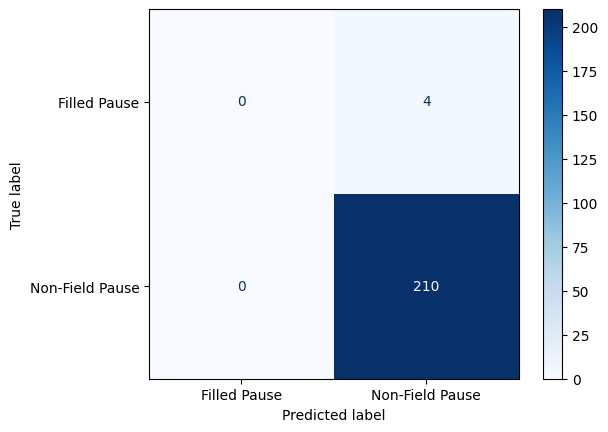

In [17]:
# Evaluate on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report and confusion matrix
y_pred = np.argmax(final_model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Filled Pause", "Non-Field Pause"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Filled Pause", "Non-Field Pause"])
disp.plot(cmap="Blues")

In [18]:
final_model.save("filled_pause_detector.h5")
print("Model saved as 'filled_pause_detector.h5'")

Model saved as 'filled_pause_detector.h5'


In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model("filled_pause_detector.h5")
print("Model loaded successfully!")

# Prepare new input data for prediction
def predict_filled_pause(segment):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=40)
    if mfcc.shape[1] < 300:
        padded_mfcc = np.pad(mfcc, ((0, 0), (0, 300 - mfcc.shape[1])), mode='constant')
    else:
        padded_mfcc = mfcc[:, :300]

    # Reshape input for the model
    input_data = np.expand_dims(padded_mfcc.T, axis=0)

    # Predict
    prediction = loaded_model.predict(input_data)
    predicted_label = np.argmax(prediction)
    return "Filled Pause" if predicted_label == 0 else "Non-Field Pause"

# Example usage
segment = X_test[0]  # Replace with your actual audio segment
prediction = predict_filled_pause(segment)
print(f"Prediction: {prediction}")